In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import sys,time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial.distance as distance
from sklearn import metrics

In [ ]:
def dist(vecA, vecB):
    return np.sqrt(np.power(vecA - vecB, 2).sum())

In [ ]:
class CureCluster:
    def __init__(self, id__, center__):
        self.points = center__
        self.repPoints = center__
        self.center = center__
        self.index = [id__]
        
    def __repr__(self):
        return "Cluster " + " Size: " + str(len(self.points))
    
    # Computes and stores the centroid of this cluster, based on its points
    def computeCentroid(self, clust):
        totalPoints_1 = len(self.index)
        totalPoints_2 = len(clust.index)
        self.center = (self.center*totalPoints_1 + clust.center*totalPoints_2) / (totalPoints_1 + totalPoints_2)
    
    # Computes and stores representative points for this cluster
    def generateRepPoints(self, numRepPoints, alpha):
        tempSet = None
        for i in range(1, numRepPoints+1):
            maxDist = 0
            maxPoint = None
            for p in range(0, len(self.index)):
                if i == 1:
                    minDist = dist(self.points[p,:], self.center)
                else:
                    X = np.vstack([tempSet, self.points[p, :]])
                    tmpDist = distance.pdist(X)
                    minDist = tmpDist.min()
                if minDist >= maxDist:
                    maxDist = minDist
                    maxPoint = self.points[p,:]
            if tempSet is None:
                tempSet = maxPoint
            else:
                tempSet = np.vstack((tempSet, maxPoint))
        for j in range(len(tempSet)):
            if self.repPoints is None:
                self.repPoints = tempSet[j,:] + alpha * (self.center - tempSet[j,:])
            else:
                self.repPoints = np.vstack((self.repPoints, tempSet[j,:] + alpha * (self.center - tempSet[j,:])))

    # Computes and stores distance between this cluster and the other one.
    def distRep(self, clust):
        distRep = float('inf')
        for repA in self.repPoints:
            if type(clust.repPoints[0]) != list:
                repB = clust.repPoints
                distTemp = dist(repA, repB)
                if distTemp < distRep:
                    distRep = distTemp
            else:
                for repB in clust.repPoints:
                    distTemp = dist(repA, repB)
                    if distTemp < distRep:
                        distRep = distTemp
        return distRep

    # Merges this cluster with the given cluster, recomputing the centroid and the representative points.
    def mergeWithCluster(self, clust, numRepPoints, alpha):
        self.computeCentroid(clust)
        self.points = np.vstack((self.points, clust.points))
        self.index = np.append(self.index, clust.index)
        self.repPoints = None
        self.generateRepPoints(numRepPoints, alpha)

In [ ]:
def runCURE(data, numRepPoints, alpha, numDesCluster):

    # Initialization for clusters
    Clusters = []
    numCluster = len(data)
    numPts = len(data)
    distCluster = np.ones([len(data), len(data)])
    distCluster = distCluster * float('inf')
    for idPoint in range(len(data)):
        newClust = CureCluster(idPoint, data[idPoint,:])
        Clusters.append(newClust)
    for row in range(0, numPts):
        for col in range(0, row):
            distCluster[row][col] = dist(Clusters[row].center, Clusters[col].center)
    while numCluster > numDesCluster:
        if np.mod(numCluster, 100) == 0:
            print('Cluster count:', numCluster)

        # Find a pair of closet clusters
        minIndex = np.where(distCluster == np.min(distCluster))
        minIndex1 = minIndex[0][0]
        minIndex2 = minIndex[1][0]

        # Merge
        Clusters[minIndex1].mergeWithCluster(Clusters[minIndex2], numRepPoints, alpha)
        # Update the distCluster matrix
        for i in range(0, minIndex1):
            distCluster[minIndex1, i] = Clusters[minIndex1].distRep(Clusters[i])
        for i in range(minIndex1+1, numCluster):
            distCluster[i, minIndex1] = Clusters[minIndex1].distRep(Clusters[i])
        # Delete the merged cluster and its disCluster vector.
        distCluster = np.delete(distCluster, minIndex2, axis=0)
        distCluster = np.delete(distCluster, minIndex2, axis=1)
        del Clusters[minIndex2]
        numCluster = numCluster - 1

    print('Cluster count:', numCluster)
    # Generate sample labels
    Label = [0] * numPts
    for i in range(0, len(Clusters)):
        for j in range(0, len(Clusters[i].index)):
            Label[Clusters[i].index[j]] = i + 1

    return Label

In [ ]:
def loadData(filename, N):
    sentences = []
    vectors = []
    with open(filename, encoding="utf-8") as file:
        data = json.load(file)
        
        count = 1
        for k , v in data.items():
            if count > N :
                break
            # print(k)
            sentences.append(k)
            vectors.append(v)
            count += 1
    return sentences, vectors

In [ ]:
def savePredict(sentences, Label_pre, file_out):
    result = {}
    for i in range(0, len(sentences)):
        if int(Label_pre[i]) in result:
            result[int(Label_pre[i])].append(int(i))
        else:
            result[int(Label_pre[i])] = [int(i)]

    with open(file_out, "w", encoding="utf-8") as fout:
        json.dump(result, fout, indent=4, ensure_ascii=False)

In [ ]:
# fastText_file = "/content/drive/MyDrive/Colab_Notebooks/Mining of massive datasets/FinalExam/fasttext_vec100.json"
# sentences_fastText, vectors_fastText = loadData(fastText_file, 10000)

In [ ]:
# data = pd.DataFrame(vectors_fastText)
# data_std = StandardScaler().fit_transform(data)
bert_file = "/content/drive/MyDrive/Colab_Notebooks/Mining of massive datasets/FinalExam/bert_vec100.json"
sentences_bert, vectors_bert = loadData(bert_file, 10000)

data_bert = pd.DataFrame(vectors_bert)
data_bert_std = StandardScaler().fit_transform(data_bert)

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_bert_std)

In [ ]:
# The number of representative points
numRepPoints = 4
# Shrink factor
alpha = 0.1
# Desired cluster number
numDesCluster = 6

start = time.time()

# data_set = np.loadtxt('/content/drive/MyDrive/Colab_Notebooks/Mining of massive datasets/Teach_n_Train/data_mining/thuchanh/data/data2_10_15clust.txt')

print("Please wait for CURE clustering to accomplete...")
Label_pre = runCURE(data_pca, numRepPoints, alpha, numDesCluster)
print("The CURE clustering is accompleted!!\n")

end = time.time()

print("The time of CURE algorithm is", end - start, "\n")

Please wait for CURE clustering to accomplete...
Cluster count: 10000
Cluster count: 9900
Cluster count: 9800
Cluster count: 9700
Cluster count: 9600
Cluster count: 9500
Cluster count: 9400
Cluster count: 9300
Cluster count: 9200
Cluster count: 9100
Cluster count: 9000
Cluster count: 8900
Cluster count: 8800
Cluster count: 8700
Cluster count: 8600
Cluster count: 8500
Cluster count: 8400
Cluster count: 8300
Cluster count: 8200
Cluster count: 8100
Cluster count: 8000
Cluster count: 7900
Cluster count: 7800
Cluster count: 7700
Cluster count: 7600
Cluster count: 7500
Cluster count: 7400
Cluster count: 7300
Cluster count: 7200
Cluster count: 7100
Cluster count: 7000
Cluster count: 6900
Cluster count: 6800
Cluster count: 6700
Cluster count: 6600
Cluster count: 6500
Cluster count: 6400
Cluster count: 6300
Cluster count: 6200
Cluster count: 6100
Cluster count: 6000
Cluster count: 5900
Cluster count: 5800
Cluster count: 5700
Cluster count: 5600
Cluster count: 5500
Cluster count: 5400
Cluster co

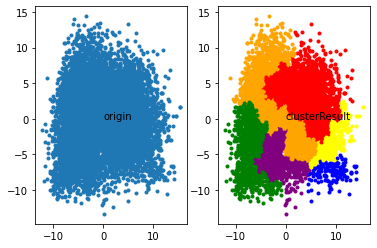

In [ ]:
# Plot the result
plt.subplot(121)
plt.scatter(data_pca[:, 0], data_pca[:, 1], marker='.')
plt.text(0, 0, "origin")
plt.subplot(122)
scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown', 'cyan', 'brown',
                 'chocolate', 'darkgreen', 'darkblue', 'azure', 'bisque', 'pink']
for i in range(data_pca.shape[0]):
    color = scatterColors[Label_pre[i]]
    plt.scatter(data_pca[i, 0], data_pca[i, 1], marker='.', c=color)
plt.text(0, 0, "clusterResult")
plt.show()

In [ ]:
# file_out = "/content/drive/MyDrive/Colab_Notebooks/Mining of massive datasets/FinalExam/Label_pre_CURE_10000_6cluster.json"
# savePredict(sentences_fastText, Label_pre, file_out)